In [7]:
import os
import sys
# add the src directory to the path
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "src"))

from ttt_pyttt import PyTTT
from utils import plot_traces
import numpy as np
from matplotlib import pyplot as plt

# Example 1: Spiking neuron


```mermaid
    graph TB
        in1((in1))
        in2((in2))
        in3((in3))
        in4((in4))
        in5((in5))
        in6((in6))

        in7((in7))
        in8((in8))
        in9((in9))
        in10((in10))
        in11((in11))
        in12((in12))

        syn1(EPSP 1)
        syn2(EPSP 2)
        syn3(EPSP 3)
        syn4(EPSP 4)
        syn5(EPSP 5)
        syn6{{IPSP 1}}

        syn7(EPSP 6)
        syn8(EPSP 7)
        syn9(EPSP 8)
        syn10(EPSP 9)
        syn11(EPSP 10)
        syn12{{IPSP 2}}

        dendrite[dendrite]
        soma[soma]

        in1 --> syn1
        in2 --> syn2
        in3 --> syn3
        in4 --> syn4
        in5 --> syn5
        in6 --> syn6

        in7 --> syn7
        in8 --> syn8
        in9 --> syn9
        in10 --> syn10
        in11 --> syn11
        in12 --> syn12

        syn1 --> dendrite
        syn2 --> dendrite
        syn3 --> dendrite
        syn4 --> dendrite
        syn5 --> dendrite
        syn6 --o dendrite

        syn7 ---> soma
        syn8 ---> soma
        syn9 ---> soma
        syn10 ---> soma
        syn11 ---> soma
        syn12 ---o soma

        dendrite --> soma
```

In [8]:
# Construct model

# 2 compartments, each 5 excitatory + 1 shunting synapse-EPSPs + spike = 14
num_nodes = 14

good_thresh = np.array([
    # 1st compartment (dendrite)
    [
        # 6 synapse-EPSPs -> triggered by single incoming spike -> threshold 1
        1, 1, 1, 1, 1, 1,
        # own spike -> triggered by coincident volley -> threshold 4
        4,
    ],
    # 2nd compartment (soma)
    [
        # 6 synapse-EPSPs -> triggered by single incoming spike -> threshold 1
        1, 1, 1, 1, 1, 1,
        # own spike -> triggered by coincident volley + dendrite -> threshold 6
        6,
    ],
]).ravel()

# 1 shunting synapse at each compartment
bad_thresh = np.array([
    # 1st compartment (dendrite)
    [
        # no bad tokens for synapses -> threshold arbitrarily 1
        1, 1, 1, 1, 1, 1,
        # shunting input -> one inhibitory spike is enough to end plateau -> threshold 1
        0,
    ],
    # 2nd compartment (soma)
    [
        # no bad tokens for synapses -> threshold arbitrarily 1
        1, 1, 1, 1, 1, 1,
        # shunting input -> one inhibitory spike is enough to end plateau -> threshold 1
        0,
    ],
]).ravel()

# good token weight matrix between the nodes
w_good = np.zeros((len(good_thresh), len(good_thresh)), dtype=np.int32)

# bad token weight matrix between the nodes
w_bad = np.zeros((len(good_thresh), len(good_thresh)), dtype=np.int32)

# each synapse is connected to the respective compartment
for comp in range(2):
    for syn in range(6):
        synapse_id = comp*7 + syn
        compartment_id = comp*7 + 6
        if syn < 5:
            # connect excitatory synapse to compartment
            w_good[compartment_id, synapse_id] = 1
        else:
            # connect shunting synapse to compartment
            w_bad[compartment_id, synapse_id] = 1

# the dendrite compartment is connected to the soma compartment
w_good[13, 6] = 3

# the pulse duration is 10 ms for excitatory EPSPs, 30ms for inhibitory EPSPs, 100ms for dendritic plateaus, 1ms for somatic spikes
pulse_duration = np.array([
    # 1st compartment (dendrite)
    [
        # 5 excitatroy synapse-EPSPs -> duration 10ms
        10, 10, 10, 10, 10, 
        # 1 inhibitory synapse-EPSP -> duration 30ms
        30,
        # own plateau -> duration 100ms
        100,
    ],
    # 2nd compartment (soma)
    [
        # 5 excitatory synapse-EPSPs -> duration 10ms
        10, 10, 10, 10, 10,
        # 1 inhibitory synapse-EPSP -> duration 30ms
        30,
        # own spike ->  duration 1ms
        1,
    ],
]).ravel()

net = PyTTT(goodThreshold=good_thresh, badThreshold=bad_thresh, W_good=w_good, W_bad=w_bad, duration=pulse_duration)
net.goodTokens, net.badTokens

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32))

In [9]:
# generate input
num_steps = 1000
dt = 1e-3
steps = np.arange(num_steps)*dt

# generate random incoming spike trains
good_tokens_in = np.random.poisson(10*dt, size=(num_steps, num_nodes))
# by default, no tokens go directly to the compartments or the shunting synapses
good_tokens_in[:, [5, 6, 12, 13]] = 0
bad_tokens_in = np.zeros_like(good_tokens_in, dtype=np.int32)

# add two volleys at time 300ms and 350ms that lead to a spike
good_tokens_in[300, [0,1,3,4]] =1 
good_tokens_in[350, [7,8,9,11]] = 1

# add another two volleys at time 600ms and 650ms that dont lead to a spike
# due to a shunting synapse
good_tokens_in[600, [0,2,3,4]] =1 
good_tokens_in[625, 5] =1 
good_tokens_in[650, [7,8,9,10]] = 1

# give each input spike a duration of 1ms
PyTTT.set_expiration(good_tokens_in, 1, circular=False)
#PyTTT.set_expiration(bad_tokens_in, 1)

# run and keep track of the generated EPSPs, spikes and plateaus
did_start = np.zeros_like(good_tokens_in, dtype=np.int32)
did_stop = np.zeros_like(good_tokens_in, dtype=np.int32)
voltage = np.zeros((num_steps, 2), dtype=np.int32)
for step,(start_token, stop_token) in enumerate(net.run(good_tokens_in, bad_tokens_in)):
    voltage[step,:] = net.goodTokens[[6,13]]
    did_start[step,:] = start_token
    did_stop[step,:] = stop_token

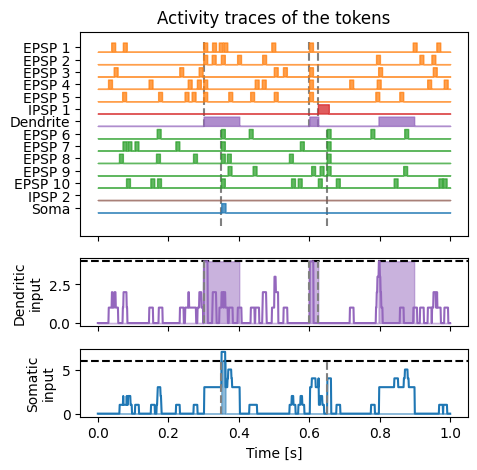

In [10]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(5, 5), height_ratios=(3,1,1))

labels= ["EPSP 1", "EPSP 2", "EPSP 3", "EPSP 4", "EPSP 5", "IPSP 1", "Dendrite", "EPSP 6", "EPSP 7", "EPSP 8", "EPSP 9", "EPSP 10", "IPSP 2", "Soma"]
colors= ["C1", "C1", "C1", "C1", "C1", "C3", "C4", "C2", "C2", "C2", "C2", "C2", "C5", "C0", ]
ax[0].vlines([0.3, 0.6, 0.625], 7.5, 14.5, color="gray", linestyle="--")
ax[0].vlines([0.35, 0.65], -0.5, 7.5, color="gray", linestyle="--")
plot_traces(steps, did_start, did_stop, ax=ax[0], labels=labels, colors=colors, alpha=0.75, zorder=10)
ax[0].set_title("Activity traces of the tokens")
ax[1].axhline(net.goodTokenThreshold[6], color="k", linestyle="--")
ax[1].fill_between(steps, np.cumsum(did_start[:,6]-did_stop[:,6], axis=0)*net.goodTokenThreshold[6], color="C4", step="pre", alpha=0.5)
ax[1].plot(steps, voltage[:,0], color="C4")
ax[1].set_ylabel("Dendritic\ninput")
ax[1].vlines([0.3, 0.6, 0.625], 0, net.goodTokenThreshold[6], color="gray", linestyle="--")
ax[2].axhline(net.goodTokenThreshold[13], color="k", linestyle="--")
ax[2].fill_between(steps, np.cumsum(did_start[:,13]-did_stop[:,13], axis=0)*net.goodTokenThreshold[13], color="C0", step="pre", alpha=0.5)
ax[2].plot(steps, voltage[:,1], color="C0")
ax[2].set_ylabel("Somatic\ninput")
ax[2].vlines([0.35, 0.65], 0, net.goodTokenThreshold[13], color="gray", linestyle="--")
ax[2].set_xlabel("Time [s]")

fig.savefig("neuron.png", dpi=300, bbox_inches="tight")
fig.savefig("neuron.svg", dpi=300, bbox_inches="tight")
fig.savefig("neuron.pdf", dpi=300, bbox_inches="tight")